In [1]:
import numpy as np
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf

In [17]:
######### UNDER CONSTRUCTION SEGMENT ###### ABORTED
def head_based_gaze_vector_calculation(block, export=False):
    """
    This function changes re_df and le_df so that they'll include the
    phi2 and theta column corresponding with the degrees from median position for the pupil in every frame
    :param block: BlockSync object to claculate for
    :param export: if true will create a .csv file for each eye
    :return:
    """
    df_dict = {
        'R': block.re_df,
        'L': block.le_df
    }
    for key in df_dict.keys():
        # iterate over eyes
        df = df_dict[key].copy()


        # add column with height / width
        s = df.height/df.width
        s[s>1] = 1 / s[s>1]
        df['h_w'] = s

        # Find Eye Center (the "roundest ellipse" condition's centerpoint)
        max_ratio = pd.to_numeric(df.h_w).idxmax()
        df['h_w'][max_ratio]
        aEC = df['center_x'][max_ratio]
        bEC = df['center_y'][max_ratio]
        # for future reference - this point should be an intersection of all minor axes, and not only an average as is the case now)

        # Find f/z0 using LEAST SQUARES
        top = 0.0
        bot = 0.0
        for row in tqdm.tqdm(range(len(df))):
            hw = df.iloc[row]['h_w']
            aPC = df.iloc[row]['center_x']
            bPC = df.iloc[row]['center_y']
            if hw == hw:
                top += math.sqrt(1 - hw**2) * math.sqrt((aPC-aEC)**2 + (bPC-bEC)**2)
                bot += (1 - hw**2)
        f_z = top / bot


        for row in tqdm.tqdm(range(len(df))):
            frame = df.iloc[row][f'{key}_eye_frame']
            if frame == frame:
                comp = 2*np.max([df.loc[row, 'height'], df.loc[row, 'width']]) / f_z
                df.loc[row, 'r'] = comp
            else:
                df.loc[row, 'r'] = np.nan

        for row in tqdm.tqdm(range(len(df))):
            frame = df.iloc[row][f'{key}_eye_frame']
            if frame == frame:
                comp_t = np.arcsin( (df.loc[row, 'center_x'] - aEC) / f_z)
                comp_p = np.arcsin( (df.loc[row, 'center_y'] - bEC) / (np.cos(comp_t)*f_z) )

                df.loc[row, 'theta'] = comp_t*180/np.pi
                df.loc[row, 'phi2'] = comp_p*180/np.pi
            else:
                df.loc[row, 'theta'] = np.nan
                df.loc[row, 'phi2'] = np.nan

        if key == 'R':
            block.right_df = df
            if export:
                df.to_csv(block.analysis_path / 'right_df.csv')
        elif key == 'L':
            block.left_df = df
            df.to_csv(block.analysis_path / 'left_df.csv')

In [63]:
# get a heatmap of saccade initiation locations:
# for the right eye:
# get the origin positions of all saccades of left eye:
l_x_start_locs = np.array([x[0] for x in stacked_synced_df.query('eye == "L"')['x_coords']])
l_y_start_locs = np.array([y[0] for y in stacked_synced_df.query('eye == "L"')['y_coords']])

global_max = np.max([np.max(l_x_start_locs),np.max(l_y_start_locs)])
global_min = np.max([np.min(l_x_start_locs),np.min(l_y_start_locs)])

x = l_x_start_locs
y = l_y_start_locs
fig, axes = plt.subplots(figsize=(10,10))
uf.plot_kde(axes,x,y,200,'left eye heatmap')

In [64]:
# get a heatmap of saccade initiation locations:
# for the right eye:
# get the origin positions of all saccades of right eye:
r_x_start_locs = np.array([x[0] for x in stacked_synced_df.query('eye == "R"')['x_coords']])
r_y_start_locs = np.array([y[0] for y in stacked_synced_df.query('eye == "R"')['y_coords']])

global_max = np.max([np.max(r_x_start_locs),np.max(r_y_start_locs)])
global_min = np.max([np.min(r_x_start_locs),np.min(r_y_start_locs)])

x = r_x_start_locs
y = r_y_start_locs
fig, axes = plt.subplots(figsize=(10,10))
uf.plot_kde(axes,x,y,200,'right eye heatmap')

In [17]:
# check what happens to this plot for single blocks:
# Assuming you have loaded stacked_synced_df DataFrame

# Get unique block numbers from the DataFrame
unique_blocks = stacked_synced_df['block'].unique()

# Set up subplots for each block
num_blocks = len(unique_blocks)
fig, axes = plt.subplots(num_blocks,2, figsize=(20, 10*num_blocks), sharex=False, sharey=False)
if num_blocks == 1:
    axes = [axes]  # Convert to a list of axes if there's only one block

# Loop through each unique block
for i, block in enumerate(unique_blocks):
    for j, eye in enumerate(['L','R']):
        if eye == 'L':
            pix_size = block_dict[block].L_pix_size
        elif eye == 'R':
            pix_size = block_dict[block].R_pix_size

        # Get saccade initiation locations for the current block
        x_start_locs = np.array([x[0] for x in np.array(stacked_synced_df.query('eye == @eye and block == @block')['x_coords'])])
        x_mean_loc = np.mean(x_start_locs)
        y_start_locs = np.array([y[0] for y in np.array(stacked_synced_df.query('eye == @eye and block == @block')['y_coords'])])
        y_mean_loc = np.mean(y_start_locs)

        # Calculate global max and min for this block
        local_max = np.max([np.max(x_start_locs), np.max(y_start_locs)])
        local_min = np.min([np.min(x_start_locs), np.min(y_start_locs)])

        x = (x_start_locs - x_mean_loc)*pix_size
        y = (y_start_locs - y_mean_loc)*pix_size

        # Plot KDE heatmap for the current block
        uf.plot_kde(axes[i,j], x, y, 200, f'Block {block} - {eye} eye Heatmap')

    # Set the same color limits for all subplots to have consistent scale
    #axes[i].set_xlim(global_min, global_max)
    #axes[i].set_ylim(global_min, global_max)

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\Spatial\synced_saccade_starting_position.pdf', format='pdf')
plt.show()

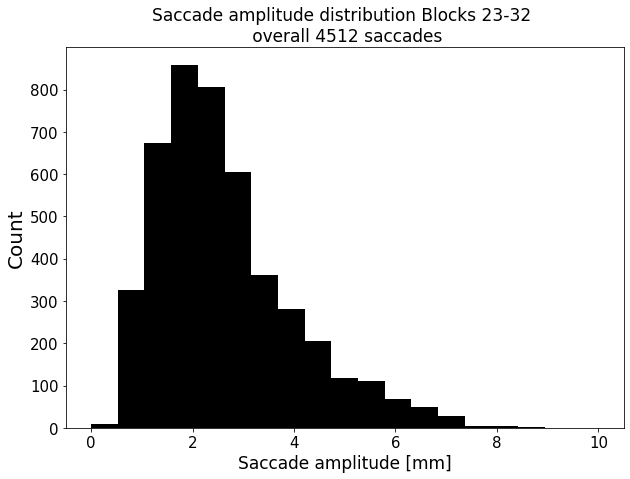

In [64]:
# create saccade amplitudes histogram:
# Get unique block numbers from the DataFrame
unique_blocks = stacked_synced_df['block'].unique()
all_magnitudes_mm = []
r_magnitudes_mm = []
for block_num in unique_blocks:

    l_magnitudes = stacked_synced_df.query('eye == "L" and block == @block_num')['magnitude']
    l_magnitudes = l_magnitudes * block_dict[block_num].L_pix_size
    all_magnitudes_mm.extend(l_magnitudes)
    r_magnitudes = stacked_synced_df.query('eye == "R" and block == @block_num')['magnitude']
    r_magnitudes = r_magnitudes * block_dict[block_num].R_pix_size
    r_magnitudes_mm.extend(r_magnitudes)

all_magnitudes_mm.extend(r_magnitudes_mm)


# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the histogram
ax.hist(all_magnitudes_mm,bins=np.linspace(0,10,20),log=True, color='black')

# Set title and labels
title = f'Saccade amplitude distribution Blocks 23-32 \n overall {len(all_magnitudes_mm)} saccades'
ax.set_title(title, fontsize=17)
ax.set_xlabel('Saccade amplitude [mm]', fontsize=17)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_ylabel('Count', fontsize=20)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=15)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')


# Save the figure as a PDF
output_path = r"D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\saccade_amplitudes_blocks_23_32_linearCount.pdf"
plt.savefig(output_path, bbox_inches='tight', format='pdf')
plt.show()

In [3]:
######## THINGS KINDA WORK FROM HERE ON IN #########

# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = range(23,33)
bad_blocks = [42, 61, 62, 64, 65, 66]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block_dict

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 025 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_025, new OE version
Found the sample rate for block 025 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 025
got it!
instantiated block number 026 at Path: Z:\Nimrod\experi

{'023': BlockSync object for animal PV_62 with 
 block_num 023 at date 2023-04-27_10-52-42,
 '024': BlockSync object for animal PV_62 with 
 block_num 024 at date 2023-04-27_11-22-56,
 '025': BlockSync object for animal PV_62 with 
 block_num 025 at date 2023-04-27_11-52-05,
 '026': BlockSync object for animal PV_62 with 
 block_num 026 at date 2023-04-27_12-21-41,
 '027': BlockSync object for animal PV_62 with 
 block_num 027 at date 2023-04-27_12-53-31,
 '028': BlockSync object for animal PV_62 with 
 block_num 028 at date 2023-04-27_13-47-38,
 '029': BlockSync object for animal PV_62 with 
 block_num 029 at date 2023-04-27_14-17-44,
 '030': BlockSync object for animal PV_62 with 
 block_num 030 at date 2023-04-27_14-45-50,
 '031': BlockSync object for animal PV_62 with 
 block_num 031 at date 2023-04-27_15-17-38,
 '032': BlockSync object for animal PV_62 with 
 block_num 032 at date 2023-04-27_15-51-55}

In [4]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
getting eye brigtness values for block 023...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
getting eye brigtness values for block 024...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 025 has a parsed events file, reading...
getting eye brigtness values for block 025...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
getting eye brigtness values for block 026...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
running parse_open_ephys_events...
block 027 has a parsed events file, reading...
ge

In [5]:
# This is a continuation of the previous - more data loadings
for block in block_collection:
    block.import_manual_sync_df()
    block.read_dlc_data()

eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder
eye dataframes loaded from analysis folder


In [5]:
"""
This function cascades over the steps that end in two dataframe objects, one for synced saccades and the other
        non-synced saccades. This function requires completion of all previous analysis steps (in particular, lizMov.mat
        should be produced using mark's code)
"""
for block in block_collection:
    print(block)
    block.saccade_dict_creation(sampling_window_ms=2000,
                                ep_channel_number=5,
                                automate_saccade_detection=True,
                                overwrite_saccade_data=False)

PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
loaded chunked saccade data from analysis folder
getting data with block_number 023: 
There are 556 saccade events: 
pre_saccade_ts = [  38430.     39126.35   39364.1    40587.     46717.75   48246.2
   50046.4    50199.3    50555.9    51116.35   51218.3    51371.1
   51710.7    53545.     53697.85   53833.75   54428.15   54581.
   55073.55   56041.65   59591.1    62800.5    65500.9    72633.85
   81686.8    86561.65   86833.4    88039.25   88158.15   88260.05
   88446.9    88514.8    88599.7    88752.6    88939.4    89007.35
   89414.9    91130.15   91571.7    92081.15   92488.75   92590.65
   93338.05   94000.35   95222.95   96394.7    98483.5    98840.2
   99111.9    99791.25  101183.75  103153.8   110796.55  115909.
  116724.35  119646.15  119833.    120240.65  121531.2   121633

In [7]:
# This cell sorts the saccade data from the BlockSync objects into dataframes
block_sync_dfs = [block.synced_saccades_df for block in block_collection]
stacked_synced_df = pd.concat(block_sync_dfs, ignore_index=True)
block_non_synced_dfs = [block.non_synced_saccades_df for block in block_collection]
stacked_non_synced_df = pd.concat(block_non_synced_dfs, ignore_index=True)

In [7]:
# sort burst Vs singular saccades
df = stacked_synced_df.query('eye=="L"')

# define the threshold for time differences between saccades
df.sort_values(by=['block','timestamps'],inplace=True)

# calculate time differences between saccades within each block:
df['time_diff'] = df.groupby('block')['timestamps'].diff()

# define the threshold for bursting saccades:
burst_threshold = 350

# create a DataFrame for bursting saccades:
burst_df = df.query('time_diff < @burst_threshold')
non_burst_df = df.query("time_diff > @burst_threshold")

burst_df.reset_index(drop=True, inplace=True)
non_burst_df.reset_index(drop=True, inplace=True)


<ipython-input-7-b01f447016c1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['block','timestamps'],inplace=True)
<ipython-input-7-b01f447016c1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_diff'] = df.groupby('block')['timestamps'].diff()


In [8]:
#!!!THIS IS FOR NON-BURSTING SACCADES!!!
# define the length of the data segment:
win_length = 50000 # ms
le_samples = []
re_samples = []
# iterate over blocks to get the timestamps, because these are synced we only need to choose one eye
for b in set(non_burst_df.block):

    saccade_ts = non_burst_df.query("eye=='L' and block==@b").timestamps.values + 1000 # +1000 ms to countermend the collection strategy
    win_starts = saccade_ts - (win_length // 2)
    win_ends = saccade_ts + (win_length // 2)
    block = block_dict[b]

    le_diameters = block.le_df
    re_diameters = block.re_df

    for i, saccade in enumerate(tqdm.tqdm(saccade_ts)):
        le_data = le_diameters.query('ms_axis > @win_starts[@i] and ms_axis < @win_ends[@i]').astype(float)
        le_samples.append(le_data['ellipse_size'].values)
        re_data = re_diameters.query('ms_axis > @win_starts[@i] and ms_axis < @win_ends[@i]').astype(float)
        re_samples.append(re_data['ellipse_size'].values)


100%|██████████| 329/329 [00:20<00:00, 16.17it/s]


(-5.0, 5.0)

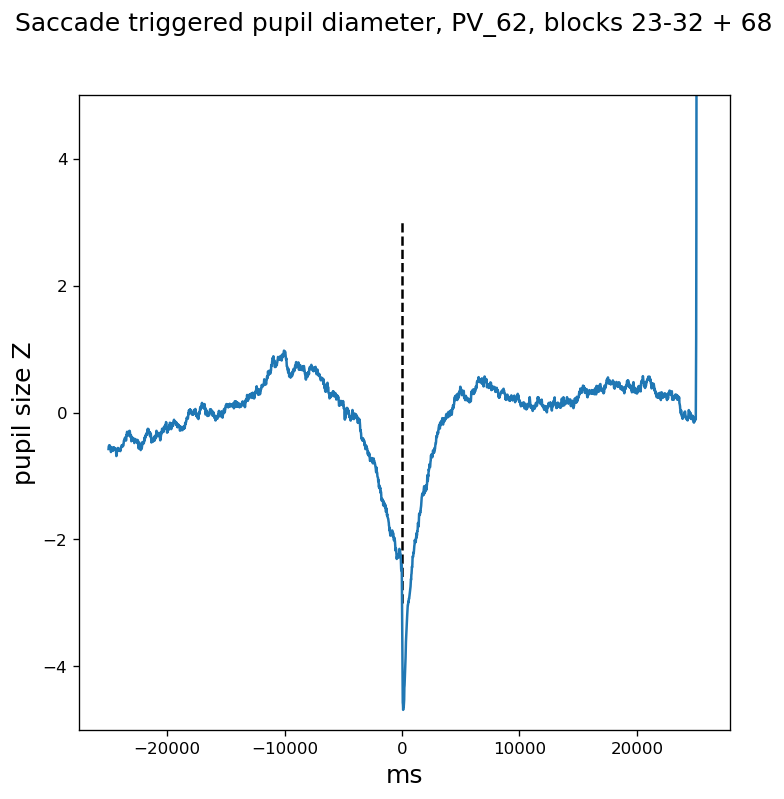

In [9]:
array_list = le_samples
max_cols = max(len(arr) for arr in array_list)
padded_arrays = [np.pad(arr, (0, max_cols - len(arr)), constant_values=np.nan) for arr in array_list]
big_array = np.vstack(padded_arrays)
mean_vec = np.nanmean(big_array,axis=0)
norm_vec = (mean_vec - np.mean(mean_vec)) / np.std(mean_vec)
fig, axs = plt.subplots(dpi=120,figsize=(7,7))
plt.suptitle(f'Saccade triggered pupil diameter, PV_62, blocks 23-32 + 68',fontsize=15)
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.set_xlabel('ms')
axs.set_ylabel('pupil size Z')
x_axis = (np.arange(0,len(mean_vec))*17) - (win_length//2)
axs.vlines(0,-3,3,linestyles='--')
axs.plot(x_axis,norm_vec)
axs.set_ylim(-5,5)
#axs.set_xlim(-10000,10000)

(-5.0, 5.0)

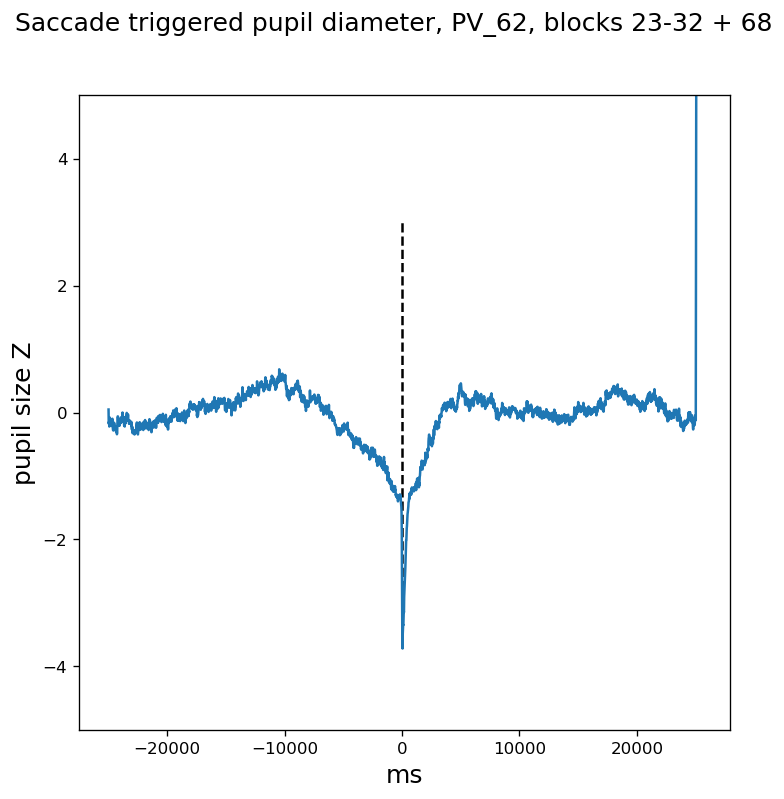

In [10]:
array_list = re_samples
max_cols = max(len(arr) for arr in array_list)
padded_arrays = [np.pad(arr, (0, max_cols - len(arr)), constant_values=np.nan) for arr in array_list]
big_array = np.vstack(padded_arrays)
mean_vec = np.nanmean(big_array,axis=0)
norm_vec = (mean_vec - np.mean(mean_vec)) / np.std(mean_vec)
fig, axs = plt.subplots(dpi=120,figsize=(7,7))
plt.suptitle(f'Saccade triggered pupil diameter, PV_62, blocks 23-32 + 68',fontsize=15)
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.set_xlabel('ms')
axs.set_ylabel('pupil size Z')
x_axis = (np.arange(0,len(mean_vec))*17) - (win_length//2)
axs.vlines(0,-3,3,linestyles='--')
axs.plot(x_axis,norm_vec)
axs.set_ylim(-5,5)
#axs.set_xlim(-10000,10000)

In [11]:
# !!! THIS IS FOR BURSTING SACCADES!!!
# define the length of the data segment:
win_length = 500000 # ms
le_samples = []
re_samples = []
# iterate over blocks to get the timestamps, because these are synced we only need to choose one eye
for b in set(burst_df.block):

    saccade_ts = burst_df.query("eye=='L' and block==@b").timestamps.values + 1000 # +1000 ms to countermend the collection strategy
    win_starts = saccade_ts - (win_length // 2)
    win_ends = saccade_ts + (win_length // 2)
    block = block_dict[b]

    le_diameters = block.le_df
    re_diameters = block.re_df

    for i, saccade in enumerate(tqdm.tqdm(saccade_ts)):
        le_data = le_diameters.query('ms_axis > @win_starts[@i] and ms_axis < @win_ends[@i]')
        le_samples.append(le_data['ellipse_size'].values)
        re_data = re_diameters.query('ms_axis > @win_starts[@i] and ms_axis < @win_ends[@i]')
        re_samples.append(re_data['ellipse_size'].values)


100%|██████████| 107/107 [00:07<00:00, 15.08it/s]


(-10000.0, 10000.0)

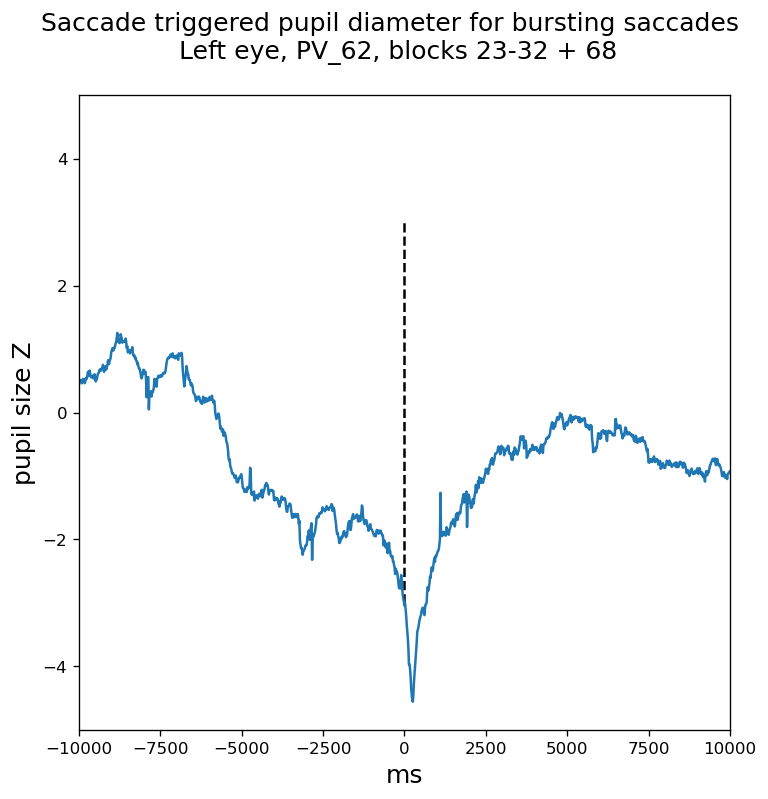

In [12]:
array_list = le_samples
max_cols = max(len(arr) for arr in array_list)
padded_arrays = [np.pad(arr, (0, max_cols - len(arr)), constant_values=np.nan) for arr in array_list]
big_array = np.vstack(padded_arrays)
mean_vec = np.nanmean(big_array,axis=0)
norm_vec = (mean_vec - np.mean(mean_vec)) / np.std(mean_vec)
fig, axs = plt.subplots(dpi=120,figsize=(7,7))
plt.suptitle(f'Saccade triggered pupil diameter for bursting saccades \n Left eye, PV_62, blocks 23-32 + 68',fontsize=15)
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.set_xlabel('ms')
axs.set_ylabel('pupil size Z')
x_axis = (np.arange(0,len(mean_vec))*17) - (win_length//2)
axs.vlines(0,-3,3,linestyles='--')
axs.plot(x_axis,norm_vec)
axs.set_ylim(-5,5)
axs.set_xlim(-10000,10000)

(-10000.0, 10000.0)

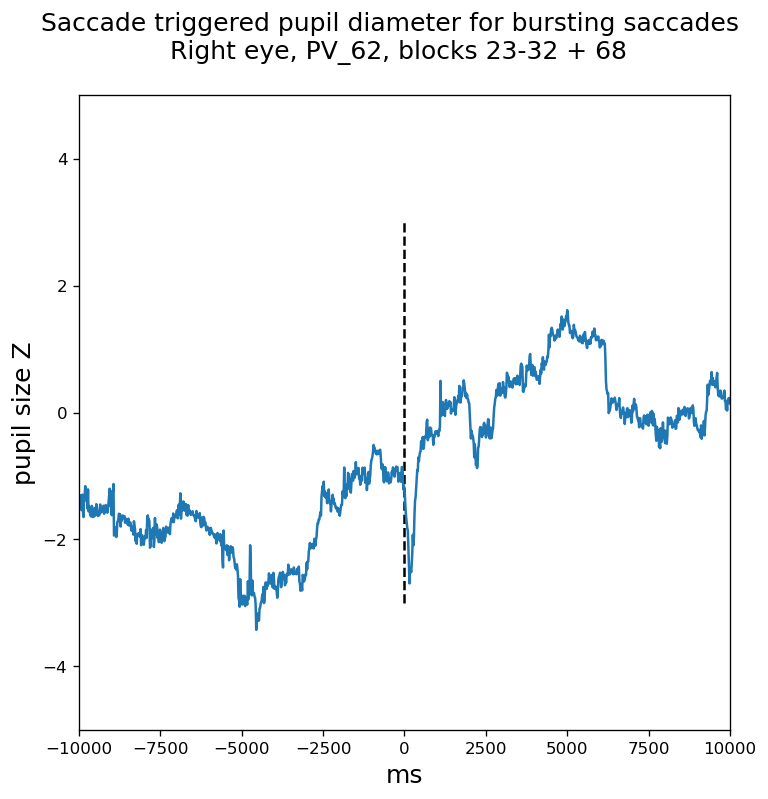

In [13]:
array_list = re_samples
max_cols = max(len(arr) for arr in array_list)
padded_arrays = [np.pad(arr, (0, max_cols - len(arr)), constant_values=np.nan) for arr in array_list]
big_array = np.vstack(padded_arrays)
mean_vec = np.nanmean(big_array,axis=0)
norm_vec = (mean_vec - np.mean(mean_vec)) / np.std(mean_vec)
fig, axs = plt.subplots(dpi=120,figsize=(7,7))
plt.suptitle(f'Saccade triggered pupil diameter for bursting saccades \n Right eye, PV_62, blocks 23-32 + 68',fontsize=15)
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.set_xlabel('ms')
axs.set_ylabel('pupil size Z')
x_axis = (np.arange(0,len(mean_vec))*17) - (win_length//2)
axs.vlines(0,-3,3,linestyles='--')
axs.plot(x_axis,norm_vec)
axs.set_ylim(-5,5)
axs.set_xlim(-10000,10000)

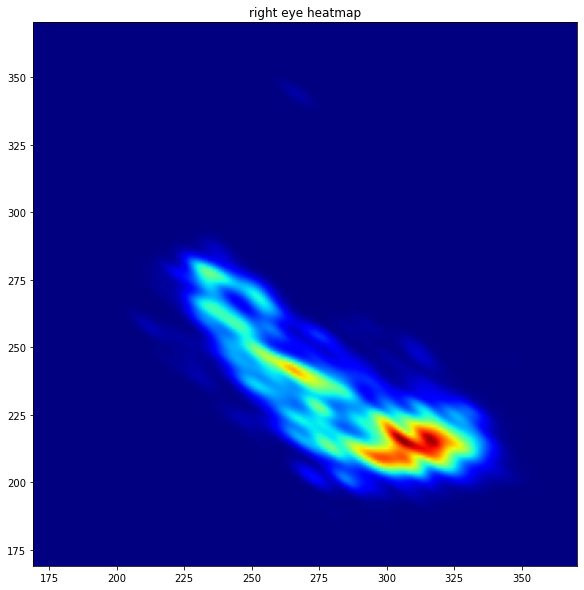

In [45]:
# this cell creates a heatmap of pupil center locations throughout one block

y_vals = block.re_df['center_y'].values
x_vals = block.re_df['center_x'].values
global_max = np.max([np.max(x_vals),np.max(y_vals)])
global_min = np.max([np.min(x_vals),np.min(y_vals)])
x_vals_clean = x_vals[np.isfinite(x_vals)]
y_vals_clean = y_vals[np.isfinite(y_vals)]

clean_x_inds = x_vals_clean == x_vals_clean
clean_y_inds = y_vals_clean == y_vals_clean

clean_x = pd.Series(data=x_vals_clean[clean_x_inds], name='x_vals', dtype='object')
clean_y = pd.Series(data=y_vals_clean[clean_y_inds], name='y_vals', dtype='object')
x = clean_x.values
y = clean_y.values
fig, axes = plt.subplots(figsize=(10,10))
uf.plot_kde(axes,x,y,200,'right eye heatmap')

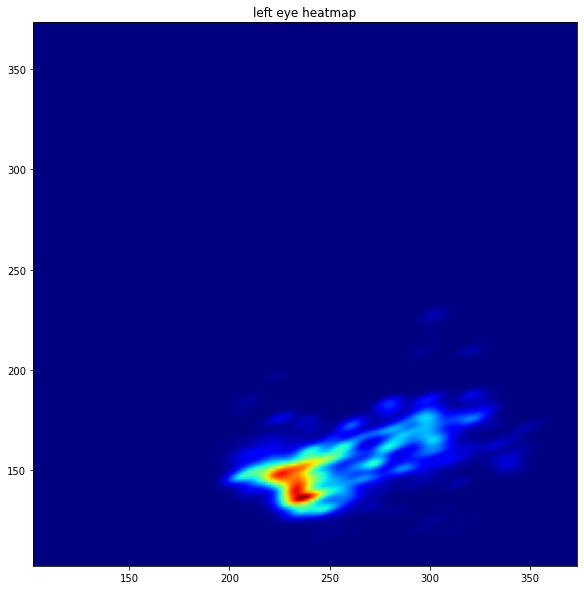

In [46]:
# this cell creates a heatmap of pupil center locations throughout one block
y_vals = block.le_df['center_y'].values
x_vals = block.le_df['center_x'].values
global_max = np.max([np.max(x_vals),np.max(y_vals)])
global_min = np.max([np.min(x_vals),np.min(y_vals)])
x_vals_clean = x_vals[np.isfinite(x_vals)]
y_vals_clean = y_vals[np.isfinite(y_vals)]

clean_x_inds = x_vals_clean == x_vals_clean
clean_y_inds = y_vals_clean == y_vals_clean

clean_x = pd.Series(data=x_vals_clean[clean_x_inds], name='x_vals', dtype='object')
clean_y = pd.Series(data=y_vals_clean[clean_y_inds], name='y_vals', dtype='object')
x = clean_x.values
y = clean_y.values
fig, axes = plt.subplots(figsize=(10,10))
uf.plot_kde(axes,x,y,200,'left eye heatmap')

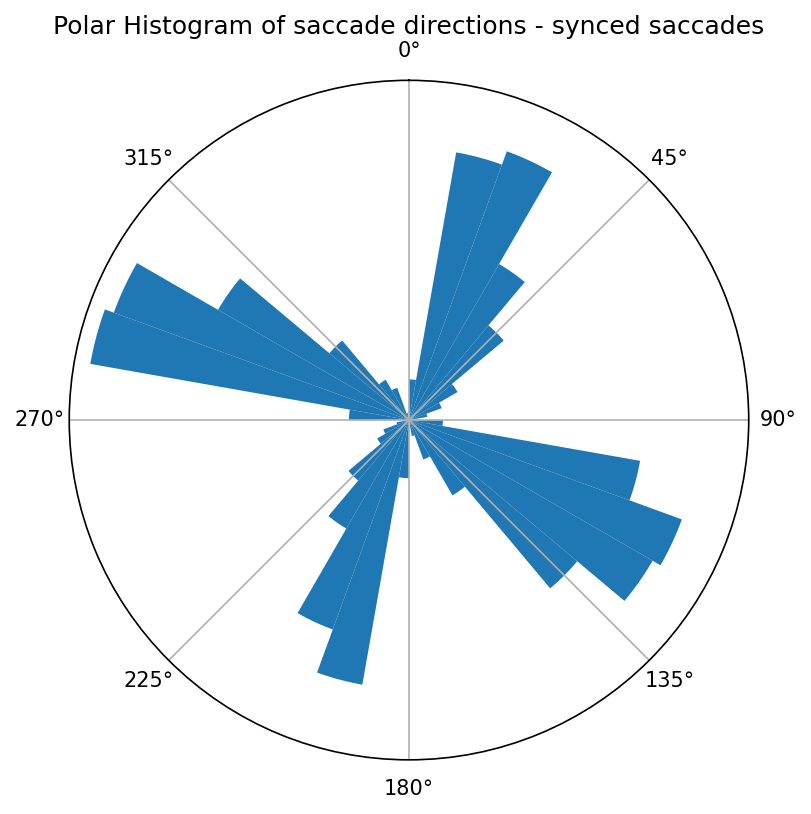

In [85]:
# Saccade direction histogram:
vals = stacked_synced_df.direction.values # synced saccades
num_bins = 36
hist, bin_edges = np.histogram(vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

ax.set_theta_direction(-1)
ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

In [87]:
for b in
stacked_synced_df

datetime block eye   timestamps  \
0      2023-04-27_10-52-42   023   L        38430   
1      2023-04-27_10-52-42   023   L      39126.3   
2      2023-04-27_10-52-42   023   L      39364.1   
3      2023-04-27_10-52-42   023   L        40587   
4      2023-04-27_10-52-42   023   L      46717.8   
...                    ...   ...  ..          ...   
10535  2023-05-18_12-06-08   068   R  3.62277e+06   
10536  2023-05-18_12-06-08   068   R  3.64533e+06   
10537  2023-05-18_12-06-08   068   R  3.64604e+06   
10538  2023-05-18_12-06-08   068   R  3.64604e+06   
10539  2023-05-18_12-06-08   068   R  3.64604e+06   

                                                      fs  \
0      [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
1      [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
2      [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
3      [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
4      [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
...                                                  ...   
10535  [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
10536  [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
10537  [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
10538  [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   
10539  [0.0, 1.220703125, 2.44140625, 3.662109375, 4....   

                                                     pxx  \
0      [21.230001477120823, 132.57830316922525, 154.1...   
1      [172.56771367747237, 513.301973360828, 312.630...   
2      [50.252659001191205, 550.345529481624, 402.680...   
3      [13.944797937505369, 74.85746732506726, 70.534...   
4      [3.109451401947336, 246.72568950784057, 482.27...   
...                                                  ...   
10535  [40.80672775425115, 220.22168667079495, 336.87...   
10536  [4.7482491432749105, 105.91370592091948, 201.3...   
10537  [16.714160553035786, 137.405826748477, 167.383...   
10538  [16.714160553035786, 137.405826748477, 167.383...   
10539  [16.714160553035786, 137.405826748477, 167.383...   

                                                 samples  \
0      [15.21, 6.63, -1.56, 11.31, -14.04000000000000...   
1      [-43.485, -19.305, -7.0200000000000005, -32.76...   
2      [-28.470000000000002, -23.400000000000002, -21...   
3      [25.35, 5.655, -21.45, -14.43, 16.575, 4.485, ...   
4      [-43.875, -56.160000000000004, -76.44, -86.385...   
...                                                  ...   
10535  [-27.69, -31.785, -56.160000000000004, -42.315...   
10536  [31.200000000000003, 16.77, 12.48, 21.84, 20.8...   
10537  [-14.625, -16.77, -22.035, -35.49, -38.61, -44...   
10538  [-14.625, -16.77, -22.035, -35.49, -38.61, -44...   
10539  [-14.625, -16.77, -22.035, -35.49, -38.61, -44...   

                                                x_coords  \
0      [181.35553973499248, 181.29654323662052, 182.5...   
1      [181.35553973499248, 181.29654323662052, 182.5...   
2      [181.35553973499248, 181.29654323662052, 182.5...   
3      [178.7543898025429, 178.7429735536779, 178.862...   
4      [202.97833793342232, 203.00929383557946, 202.9...   
...                                                  ...   
10535  [534.3980573032895, 534.4213860460732, 534.326...   
10536  [543.0452465030722, 542.9823420870424, 542.978...   
10537  [543.9172532490953, 543.9565888045521, 543.791...   
10538  [543.9172532490953, 543.9565888045521, 543.791...   
10539  [543.9172532490953, 543.9565888045521, 543.791...   

                                                y_coords  \
0      [192.2391691082757, 191.9051393362668, 193.229...   
1      [192.2391691082757, 191.9051393362668, 193.229...   
2      [192.2391691082757, 191.9051393362668, 193.229...   
3      [211.20660922295718, 211.39517637215664, 211.4...   
4      [201.63188326069908, 201.4539524063485, 201.42...   
...                                                  ...   
10535  [315.3367174584785, 315.8784980468177, 315.585...   
10536  [340.90072

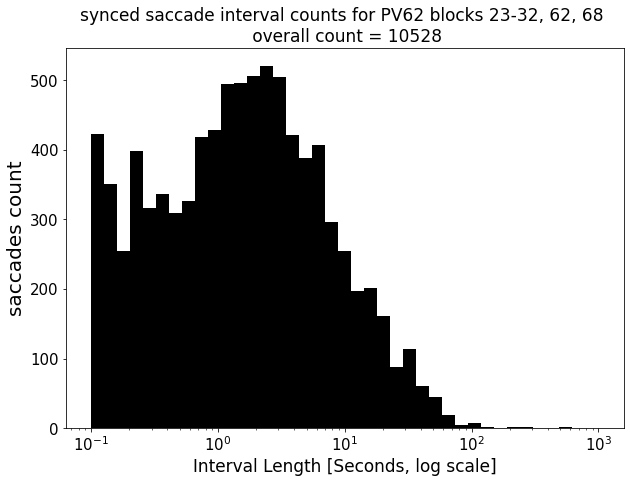

In [120]:
# create the synced saccades interval graph for the blocks I have analyzed already
saccade_intervals = []
for b in set(stacked_synced_df.block):
    single_block_df = stacked_synced_df.query('block==@b')
    single_block_intervals = np.diff(single_block_df['timestamps'][:])
    saccade_intervals.append(single_block_intervals)
all_intervals = np.hstack(saccade_intervals)


"""
original version:
fig,ax = plt.subplots(figsize=(10,7))
ax.hist(all_intervals / 1000, bins=np.geomspace(0.1,1000,30),log=True,rwidth=1)
fig.suptitle(f'synced saccade interval counts for PV62 blocks 23-32, 62, 68 \n overall count = {len(all_intervals)}',fontsize=14)
ax.set_xlabel('Interval Length [Seconds, log scale]')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_ylabel('saccades count, linear scale')
ax.xaxis.label.set_size(17)
ax.yaxis.label.set_size(17)
plt.savefig("D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\synced_saccade_interval_counts_for_PV62.pdf")
"""

# tidy graph creator:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the histogram
ax.hist(all_intervals / 1000, bins=np.geomspace(0.1, 1000, 35), log=True, rwidth=1, color='black')

# Set title and labels
title = f'synced saccade interval counts for PV62 blocks 23-32, 62, 68 \n overall count = {len(all_intervals)}'
ax.set_title(title, fontsize=17)
ax.set_xlabel('Interval Length [Seconds, log scale]', fontsize=17)
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_ylabel('saccades count', fontsize=20)

# Adjust tick label sizes
ax.tick_params(axis='both', which='major', labelsize=15)

# Set white background and black text
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.title.set_color('black')
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(colors='black')

# Save the figure as a PDF
output_path = r"D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\synced_saccade_interval_counts_for_PV62_logYscale.pdf"
#plt.savefig(output_path, bbox_inches='tight', format='pdf')

plt.show()

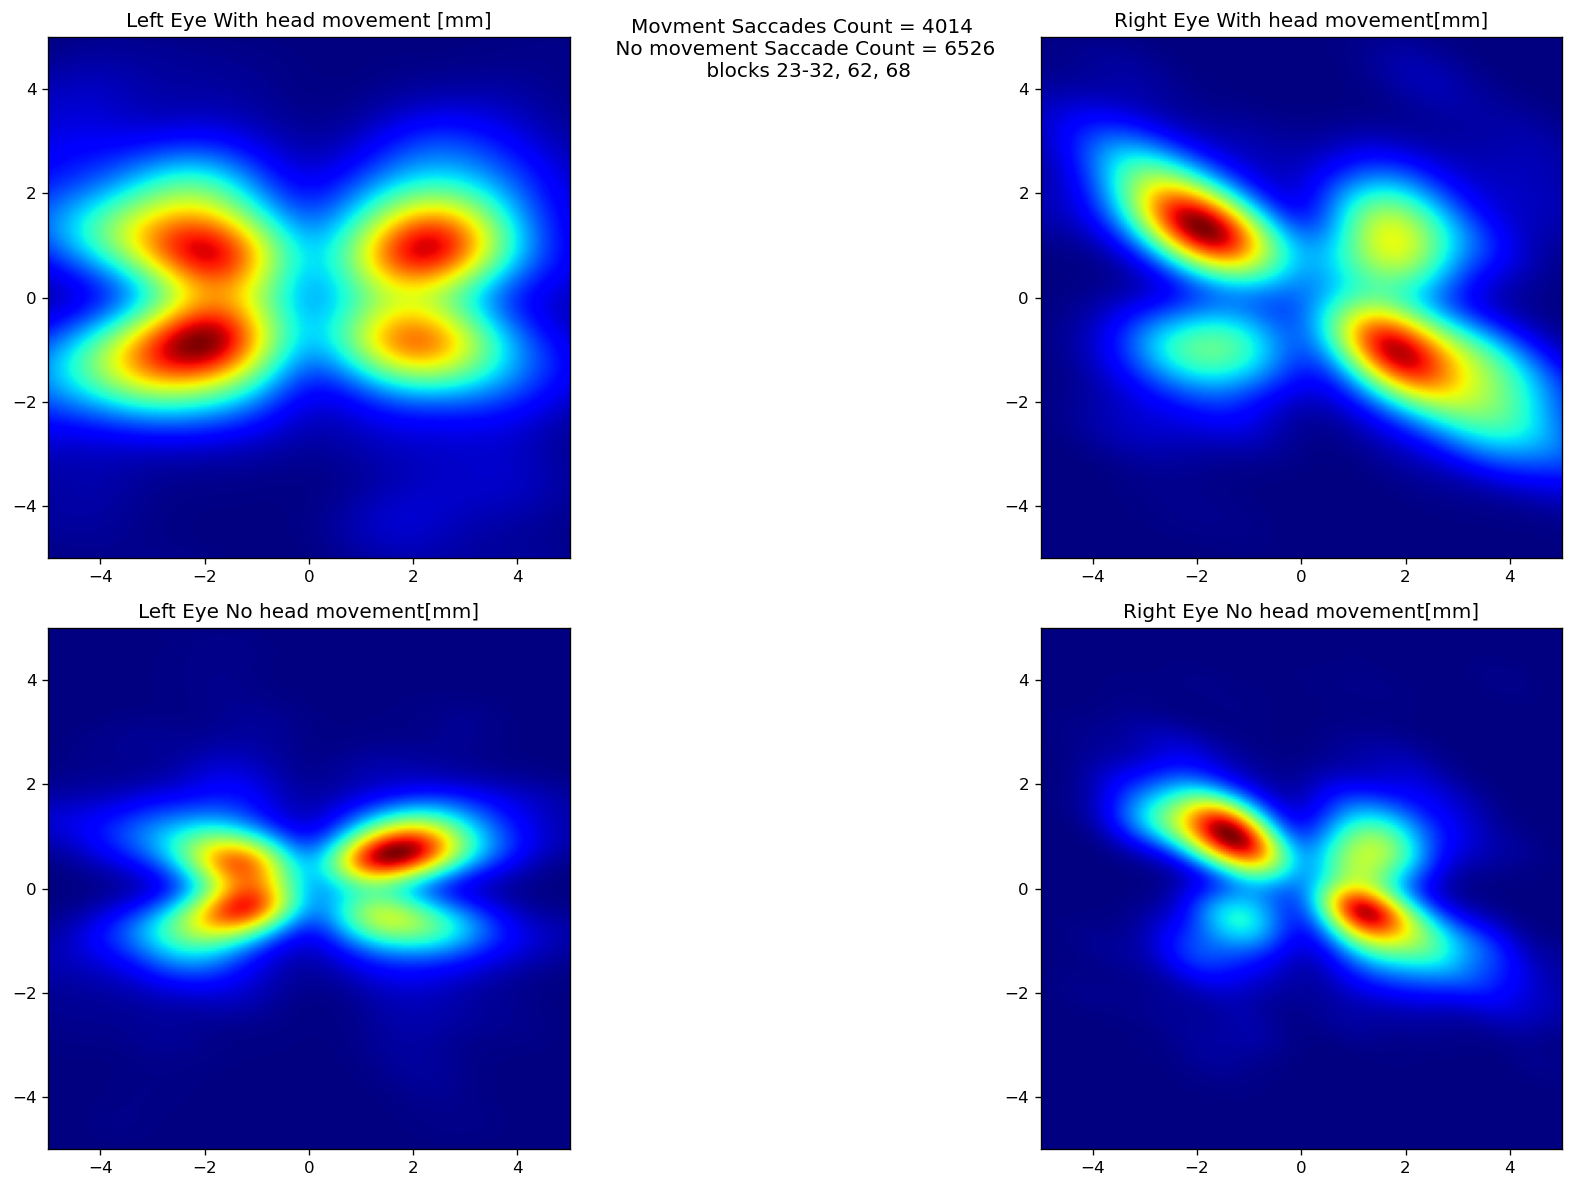

In [19]:
# this cell creates the synced saccades heatmap:

# I can now query the data I want to analyze, let's take all the 0 accel magnitude saccades:
no_accel_df = stacked_synced_df.query("accel == 0")
all_accel_df = stacked_synced_df.query("accel != 0")

# I can produce the KDE graphs for them:
# parse queries:
la_x = all_accel_df.query('eye == "L"')['calib_dx']
la_y = all_accel_df.query('eye == "L"')['calib_dy']
ra_y = all_accel_df.query('eye == "R"')['calib_dy']
ra_x = all_accel_df.query('eye == "R"')['calib_dx']

ln_x = no_accel_df.query('eye == "L"')['calib_dx']
ln_y = no_accel_df.query('eye == "L"')['calib_dy']
rn_y = no_accel_df.query('eye == "R"')['calib_dy']
rn_x = no_accel_df.query('eye == "R"')['calib_dx']

#understand graph bounderies:
x_stack = np.concatenate([la_x,ra_x,ln_x,rn_x])
y_stack = np.concatenate([la_y,ra_y,ln_y,rn_y])
global_max = np.max(np.concatenate([x_stack,y_stack]))
global_min = np.min(np.concatenate([x_stack,y_stack]))

#xlim = (np.min(x_stack), np.max(x_stack))
#ylim = (np.min(y_stack), np.max(y_stack))
global_max = 5
global_min = -5
# create the graph
fig, axes = plt.subplots(ncols=2, nrows=2, figsize =(10*2,5*2), dpi=120)
uf.plot_kde(axes[0,0],la_x,la_y,200,'Left Eye With head movement [mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[0,1],ra_x,ra_y,200,'Right Eye With head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,0],ln_x,ln_y,200,'Left Eye No head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,1],rn_x,rn_y,200,'Right Eye No head movement[mm]',global_max=global_max,global_min=global_min)
fig.suptitle(f"Movment Saccades Count = {len(all_accel_df)} \n No movement Saccade Count = {len(no_accel_df)} \n blocks 23-32, 62, 68")
fig.tight_layout()
# Save the figure as a PDF
output_path = r"D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\synced_saccade_heatmap_blocks_23to32_62_68.pdf"
plt.savefig(output_path, bbox_inches='tight', format='pdf')

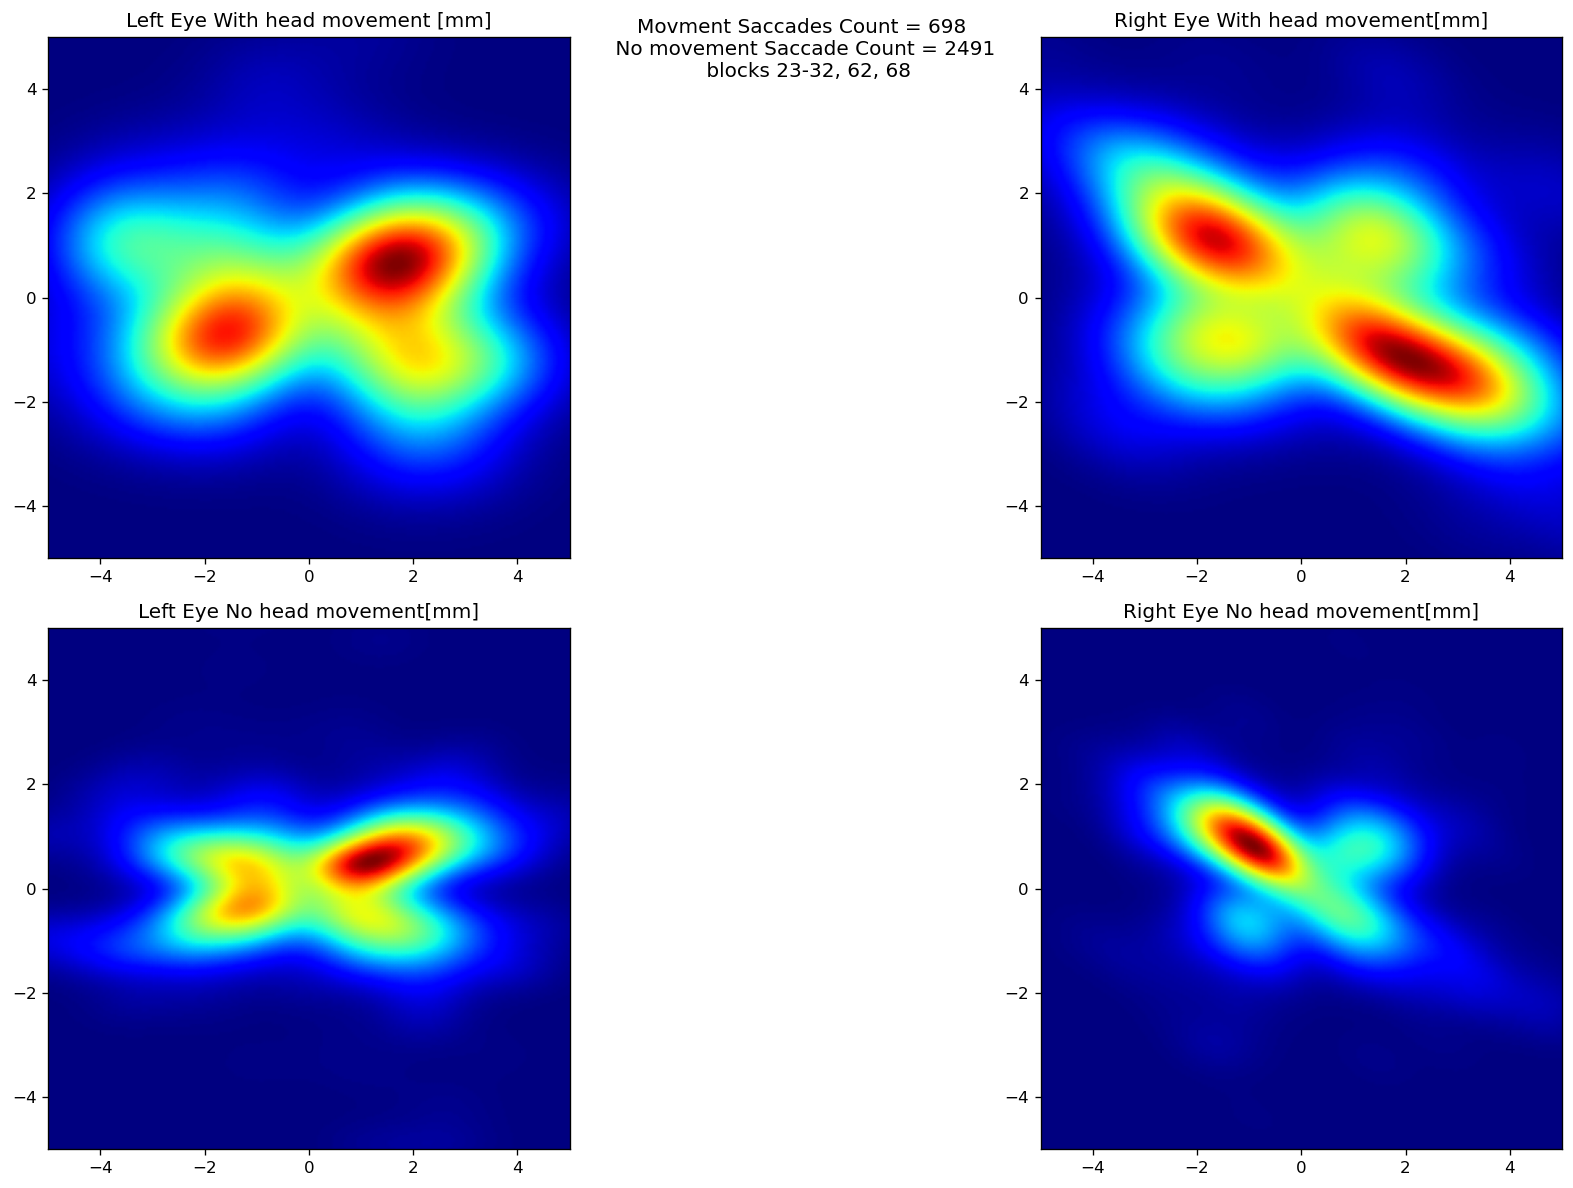

In [51]:
# this cell creates the NON_synced saccades heatmap:

# I can now query the data I want to analyze, let's take all the 0 accel magnitude saccades:
no_accel_df = stacked_non_synced_df.query("accel == 0")
all_accel_df = stacked_non_synced_df.query("accel != 0")

# I can produce the KDE graphs for them:
# parse queries:
la_x = all_accel_df.query('eye == "L"')['calib_dx']
la_y = all_accel_df.query('eye == "L"')['calib_dy']
ra_y = all_accel_df.query('eye == "R"')['calib_dy']
ra_x = all_accel_df.query('eye == "R"')['calib_dx']

ln_x = no_accel_df.query('eye == "L"')['calib_dx']
ln_y = no_accel_df.query('eye == "L"')['calib_dy']
rn_y = no_accel_df.query('eye == "R"')['calib_dy']
rn_x = no_accel_df.query('eye == "R"')['calib_dx']

#understand graph bounderies:
x_stack = np.concatenate([la_x,ra_x,ln_x,rn_x])
y_stack = np.concatenate([la_y,ra_y,ln_y,rn_y])
global_max = np.max(np.concatenate([x_stack,y_stack]))
global_min = np.min(np.concatenate([x_stack,y_stack]))

#xlim = (np.min(x_stack), np.max(x_stack))
#ylim = (np.min(y_stack), np.max(y_stack))
global_max = 5
global_min = -5
# create the graph
fig, axes = plt.subplots(ncols=2, nrows=2, figsize =(10*2,5*2), dpi=120)
uf.plot_kde(axes[0,0],la_x,la_y,200,'Left Eye With head movement [mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[0,1],ra_x,ra_y,200,'Right Eye With head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,0],ln_x,ln_y,200,'Left Eye No head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,1],rn_x,rn_y,200,'Right Eye No head movement[mm]',global_max=global_max,global_min=global_min)
fig.suptitle(f"Movment Saccades Count = {len(all_accel_df)} \n No movement Saccade Count = {len(no_accel_df)} \n blocks 23-32, 62, 68")
fig.tight_layout()
output_path = r"D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\non_synced_saccade_heatmap_blocks_23to32_62_68.pdf"
plt.savefig(output_path, bbox_inches='tight', format='pdf')

In [92]:
# post saccade pupil response
#ts = block.synced_saccades_df.timestamps.values + 1000 # old version took in both eyes
ts = block.synced_saccades_df.query('eye=="L"').timestamps.values + 1000
le_diameters = block.le_df
re_diameters = block.re_df
le_samples = []
re_samples = []
for saccade in tqdm.tqdm(ts):
    le_data = le_diameters.query('ms_axis > @saccade-5000 and ms_axis < @saccade+5000')
    le_samples.append(le_data['ellipse_size'].values)
    re_data = re_diameters.query('ms_axis > @saccade-5000 and ms_axis < @saccade+5000')
    re_samples.append(re_data['ellipse_size'].values)

100%|██████████| 387/387 [00:03<00:00, 112.32it/s]


In [94]:
# define the length of the data segment:
win_length = 500000 # ms
block = block_collection[-1]
# get the timestamps, because these are synced we only need to choose one eye
saccade_ts = block.synced_saccades_df.query("eye=='L'").timestamps.values + 1000 # +1000 ms to countermend the collection strategy
win_starts = saccade_ts - (win_length // 2)
win_ends = saccade_ts + (win_length // 2)

le_diameters = block.le_df
re_diameters = block.re_df
le_samples = []
re_samples = []
for i, saccade in enumerate(tqdm.tqdm(saccade_ts)):
    le_data = le_diameters.query('ms_axis > @win_starts[@i] and ms_axis < @win_ends[@i]')
    le_samples.append(le_data['ellipse_size'].values)
    re_data = re_diameters.query('ms_axis > @win_starts[@i] and ms_axis < @win_ends[@i]')
    re_samples.append(re_data['ellipse_size'].values)

100%|██████████| 1134/1134 [01:26<00:00, 13.08it/s]


In [91]:
block.synced_saccades_df.query('eye=="L"').timestamps.values

array([35879.35, 37442.0, 37510.0, 38631.35, 38767.3, 38971.2, 47956.75,
       66354.2, 70125.8, 71994.7, 78246.2, 83970.8, 85363.85, 94317.55,
       100570.1, 100723.0, 100943.85, 101028.8, 103016.05, 103763.3,
       104001.1, 104612.55, 104680.5, 105207.05, 106022.25, 110269.35,
       110405.25, 110490.25, 112341.95, 130028.25, 130639.9, 130707.85,
       130894.75, 130962.70000000001, 131387.4, 131659.2, 132083.85,
       132559.5, 133612.8, 136415.35, 136585.2, 136806.05, 140882.65,
       141409.35, 142547.65, 142615.6, 144535.55, 147203.05, 150074.15,
       153080.85, 163189.8, 167233.6, 167335.55, 168066.2, 168134.15,
       169323.5, 172688.05, 174557.0, 179959.5, 180112.4, 188231.95,
       188860.45, 189709.9, 213645.15, 215343.9, 219352.7, 219709.45,
       219794.45, 219930.3, 222376.0, 223836.65, 223921.55, 225297.2,
       226689.7, 232633.1, 232989.75, 233889.75, 242974.45, 266987.05,
       268074.0, 268566.5, 270230.75, 271232.65, 285684.3, 292493.6,
       293359

(-4.0, 4.0)

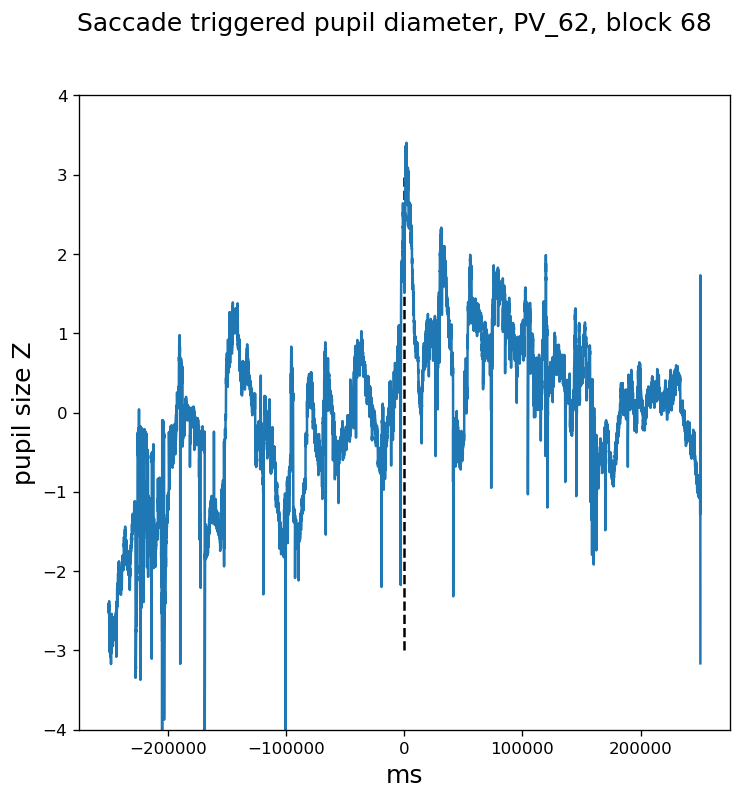

In [95]:
array_list = le_samples
max_cols = max(len(arr) for arr in array_list)
padded_arrays = [np.pad(arr, (0, max_cols - len(arr)), constant_values=np.nan) for arr in array_list]
big_array = np.vstack(padded_arrays)
mean_vec = np.nanmean(big_array,axis=0)
norm_vec = (mean_vec - np.mean(mean_vec)) / np.std(mean_vec)
fig, axs = plt.subplots(dpi=120,figsize=(7,7))
plt.suptitle(f'Saccade triggered pupil diameter, PV_62, block 68',fontsize=15)
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.set_xlabel('ms')
axs.set_ylabel('pupil size Z')
x_axis = (np.arange(0,len(mean_vec))*17) - (win_length//2)
axs.vlines(0,-3,3,linestyles='--')
axs.plot(x_axis,norm_vec)
axs.set_ylim(-4,4)

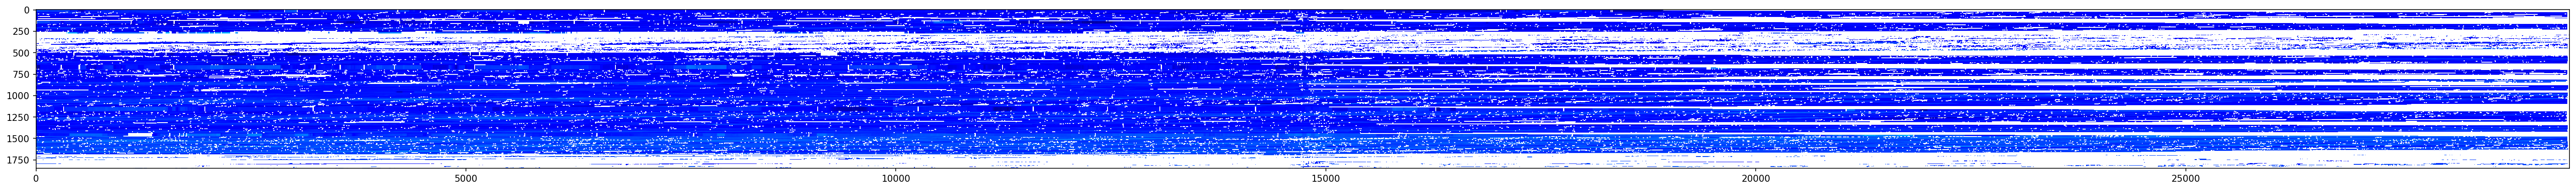

In [135]:
fig, axs = plt.subplots(figsize=(50,50), dpi=150)
axs.imshow(big_array, cmap='jet', interpolation=None)
#colorbar = plt.colorbar(im)
#plt.savefig(r'D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\trial_no_interp.pdf',format='pdf')